In [1]:
%matplotlib notebook
%config IPCompleter.greedy=True

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import scipy.stats as st
from scipy.optimize import curve_fit

pd.options.display.max_rows = 10

In [2]:
# carrega os dados

text_files = [open("file_titles_ht.txt", "r"), open("file_titles_nt.txt", "r"), open("file_titles_pb.txt", "r")]
file_titles = [[x.strip() for x in text_files[0].readlines()],
               [x.strip() for x in text_files[1].readlines()],
               [x.strip() for x in text_files[2].readlines()]]
text_files[0].close(); text_files[1].close(); text_files[2].close()


number_of_subjects = [len(file_titles[0]), len(file_titles[1]), len(file_titles[2])]
seg_res = [[], [], []]
data = [[], [], []]
for j in [0, 1, 2]:
    for i in range(number_of_subjects[j]):
        data[j].append(pd.read_csv("dados/dados_brutos_com_saltos/"+file_titles[j][i][15:]+".csv", index_col = 0))

folder = ["dados/segmentation_dataframes_hypertensive/",
          "dados/segmentation_dataframes_normotensive/",
          "dados/segmentation_dataframes_proband/"]
series = ["Serie 0", "Serie 1", "Serie 2", "Serie 3"]
for j in [0, 1, 2]:    
    for i in range(number_of_subjects[j]):
        temp = [pd.DataFrame()]*4

        for k in range(4):
            temp[k] = pd.read_csv(folder[j]+file_titles[j][i][15:][:-4]+"_"+series[k]+".csv").set_index("index")
            length = len(temp[k].index)

        seg_res[j].append(temp.copy())

In [4]:
# deleta os segmentos com fase indeterminada ou com frequência máxima menor que 85%

for i in range(3):
    for j in range(len(seg_res[i])):
        for k in range(4):
            seg_res[i][j][k] = seg_res[i][j][k].drop(seg_res[i][j][k][seg_res[i][j][k]["SleepStage"] == 66.0].index)
            for l in seg_res[i][j][k].index:
                if max(seg_res[i][j][k].loc[l, "0_%":"66_%"]) < 0.85:
                    seg_res[i][j][k] = seg_res[i][j][k].drop(l)

# aglutinação das estatísticas dos segmentos de todos os sujeitos para a série SBP

medias     = [[], [], []]
medianas   = [[], [], []]
variancias = [[], [], []]
tamanhos   = [[], [], []]
t_inicio   = [[], [], []]
t_final    = [[], [], []]
delta_t    = [[], [], []]

for grupo in [0, 1, 2]:
    medias_series_temp     = [[], [], [], []]
    medianas_series_temp   = [[], [], [], []]
    variancias_series_temp = [[], [], [], []]
    tamanhos_series_temp   = [[], [], [], []]
    t_inicio_series_temp   = [[], [], [], []]
    t_final_series_temp    = [[], [], [], []]
    delta_t_series_temp    = [[], [], [], []]
    
    for serie in [0, 1, 2, 3]:
        # Isso pode ser simplificado se eu reenumerar as fases
        medias_temp     = [[], [], [], [], [], []]
        medianas_temp   = [[], [], [], [], [], []]
        variancias_temp = [[], [], [], [], [], []]
        tamanhos_temp   = [[], [], [], [], [], []]
        t_inicio_temp   = [[], [], [], [], [], []]
        t_final_temp    = [[], [], [], [], [], []]
        delta_t_temp    = [[], [], [], [], [], []]

        for i in range(len(data[grupo])): 
            df = seg_res[grupo][i][serie]  
            for j in [0, 1, 2, 3, 4, 5]:
                for index in df.where(df["SleepStage"] == j).dropna().index:
                    medias_temp[j].append(df["mean"][index])
                    medianas_temp[j].append(df["Median"][index])
                    variancias_temp[j].append(df["variance"][index])
                    tamanhos_temp[j].append(df["finish"][index] - df["start"][index])
                    t_inicio_temp[j].append(df["T_i"][index])
                    t_final_temp[j].append(df["T_f"][index])
                    delta_t_temp[j].append(df["Dt"][index])

        # Coloca os valores em escala logaritmica.
        for i in range(6):
            variancias_temp[i] = np.log(np.asarray(variancias_temp[i]))
            tamanhos_temp[i]   = np.log(np.asarray(tamanhos_temp[i]))
            medias_temp[i]     = np.log(np.asarray(medias_temp[i]))
            medianas_temp[i]   = np.log(np.asarray(medianas_temp[i]))
            # transforma as listas restantes em arrays
            t_inicio_temp[i]   = np.asarray(t_inicio_temp[i])
            t_final_temp[i]    = np.asarray(t_final_temp[i])
            delta_t_temp[i]    = np.asarray(delta_t_temp[i])
        
        medias_series_temp[serie]     = medias_temp
        medianas_series_temp[serie]   = medianas_temp
        variancias_series_temp[serie] = variancias_temp
        tamanhos_series_temp[serie]   = tamanhos_temp
        t_inicio_series_temp[serie]   = t_inicio_temp
        t_final_series_temp[serie]    = t_final_temp
        delta_t_series_temp[serie]    = delta_t_temp
    
    medias[grupo]       = medias_series_temp
    medianas[grupo]     = medianas_series_temp
    variancias[grupo]   = variancias_series_temp
    tamanhos[grupo]     = tamanhos_series_temp
    t_inicio[grupo]     = t_inicio_series_temp
    t_final[grupo]      = t_final_series_temp
    delta_t[grupo]      = delta_t_series_temp

##### saltos[grupo][serie][fase_do_sono]

In [ ]:
# carrega os saltos

saltos = [[[], [], [], []],
          [[], [], [], []],
          [[], [], [], []]]

for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
        saltos_temp = [ [],
                        [],
                        [],
                        [],
                        [],
                        [] ]
        n_saltos = ["Serie 0 Saltos", "Serie 1 Saltos", "Serie 2 Saltos", "Serie 3 Saltos"]

        for i in range(len(data[grupo])):
            sep_seg_fase = [seg_res[grupo][i][serie][ seg_res[grupo][i][serie]["SleepStage"] == 0 ],
                            seg_res[grupo][i][serie][ seg_res[grupo][i][serie]["SleepStage"] == 1 ],
                            seg_res[grupo][i][serie][ seg_res[grupo][i][serie]["SleepStage"] == 2 ],
                            seg_res[grupo][i][serie][ seg_res[grupo][i][serie]["SleepStage"] == 3 ],
                            seg_res[grupo][i][serie][ seg_res[grupo][i][serie]["SleepStage"] == 4 ],
                            seg_res[grupo][i][serie][ seg_res[grupo][i][serie]["SleepStage"] == 5 ]]
            for j in range(6):
                for k in sep_seg_fase[j].index:
                    start =  int(sep_seg_fase[j]["start"][k])
                    finish = int(sep_seg_fase[j]["finish"][k])
                    saltos_temp[j].extend(list(data[grupo][i][start:finish+1][n_saltos[serie]]))
                #saltos_temp[j] = [np.abs(x) for x in saltos_temp[j] if x != 0.0]

        saltos[grupo][serie] = [ pd.Series(saltos_temp[0]).dropna(),
                                 pd.Series(saltos_temp[1]).dropna(),
                                 pd.Series(saltos_temp[2]).dropna(),
                                 pd.Series(saltos_temp[3]).dropna(),
                                 pd.Series(saltos_temp[4]).dropna(),
                                 pd.Series(saltos_temp[5]).dropna()]

# Calcula os valores absolutos dos saltos.

for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
        for fase in [0, 1, 2, 3, 4, 5]:
            saltos[grupo][serie][fase] = pd.Series([np.abs(x) for x in saltos[grupo][serie][fase] if x != 0]).dropna()

##### Cálculo das médias.

In [ ]:
t_series = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_valores = ["Mean", "Median", "Var", "Length", "T_i", "T_f", "D_t"]
t_grupos = ["Hypertensive", "Normotensive", "Proband"]
medidas = [medias, medianas, variancias, tamanhos, t_inicio, t_final, delta_t]

col = ["0: Mean", "0: Var", "0: SD", "0: SE",
       "1: Mean", "1: Var", "1: SD", "1: SE",
       "2: Mean", "2: Var", "2: SD", "2: SE",
       "3: Mean", "3: Var", "3: SD", "3: SE",
       "4: Mean", "4: Var", "4: SD", "4: SE",
       "REM: Mean", "REM: Var", "REM: SD", "REM: SE"]

vals = [["0: Mean", "0: Var", "0: SD", "0: SE"],
        ["1: Mean", "1: Var", "1: SD", "1: SE"],
        ["2: Mean", "2: Var", "2: SD", "2: SE"],
        ["3: Mean", "3: Var", "3: SD", "3: SE"],
        ["4: Mean", "4: Var", "4: SD", "4: SE"],
        ["REM: Mean", "REM: Var", "REM: SD", "REM: SE"]]

for grupo in range(3):
    for serie in range(4):
        valores = pd.DataFrame(columns = col, index = t_valores)
        
        for x in range(6):
            for y in range(7):
                valores[vals[x][0]][t_valores[y]] = medidas[y][grupo][serie][x].mean()
                valores[vals[x][1]][t_valores[y]] = medidas[y][grupo][serie][x].std()
                valores[vals[x][2]][t_valores[y]] = medidas[y][grupo][serie][x].var()
                valores[vals[x][3]][t_valores[y]] = st.sem(medidas[y][grupo][serie][x])
                
        valores.to_csv("dados/Medidas_avg_std_var/"+t_grupos[grupo]+"/5 Fases/"+t_series[serie]+".csv")

##### Kruskal–Wallis one-way analysis of variance

In [8]:
idx = ["Mean", "Median", "Variance", "Length", "T_i", "T_f", "D_t", "Alpha"]
medidas = [medias, medianas, variancias, tamanhos, t_inicio, t_final, delta_t, a_coefficients]
series = ["Series 0", "Series 1", "Series 2", "Series 3"]

hypertensive_df = pd.DataFrame(columns = series, index = idx)
normotensive_df = pd.DataFrame(columns = series, index = idx)
proband_df      = pd.DataFrame(columns = series, index = idx)

grupos = [hypertensive_df, normotensive_df, proband_df]

for g in range(3):
    for s in range(4):
        for m in range(len(medidas)):
            temp = medidas[m][g][s]
            grupos[g][series[s]][idx[m]] = st.kruskal(temp[0], temp[1], temp[2], temp[3], temp[4], temp[5])[1]

In [9]:
hypertensive_df

,Series 0,Series 1,Series 2,Series 3
Mean,4.91243e-18,1.22652e-08,2.91061e-33,2.04801e-37
Median,2.90064e-17,2.17531e-08,1.01316e-32,6.37343e-37
Variance,4.96014e-16,3.05978e-12,4.3665e-20,4.39536e-24
Length,7.66227e-09,3.03478e-07,7.21428e-11,2.27949e-07
T_i,4.175e-35,6.516e-30,8.94915e-36,5.04309e-33
T_f,5.86949e-35,7.65071e-30,1.67597e-35,5.50787e-33
D_t,1.85067e-15,1.86561e-12,1.9921e-18,6.41865e-15
Alpha,5.80664e-10,2.36419e-10,3.12951e-10,1.01207e-12


In [10]:
normotensive_df

,Series 0,Series 1,Series 2,Series 3
Mean,2.24717e-58,6.46591e-60,7.49378e-09,5.15381e-07
Median,7.90966e-58,4.73426e-60,5.65837e-09,2.64668e-07
Variance,1.9312e-49,7.35742e-79,5.49867e-17,6.1525e-16
Length,1.33344e-26,3.75867e-19,5.01326e-45,2.31837e-36
T_i,7.97878e-48,2.48937e-40,8.62116e-29,7.72837e-35
T_f,1.1856e-47,3.78341e-40,3.43511e-28,4.60384e-34
D_t,9.0888e-33,8.59017e-27,4.33988e-40,2.67372e-30
Alpha,1.57286e-86,2.48899e-63,2.12988e-49,1.79688e-44


In [11]:
proband_df

,Series 0,Series 1,Series 2,Series 3
Mean,5.12115e-07,0.0674166,8.72031e-17,8.72031e-17
Median,2.17666e-07,0.0396487,1.02618e-15,1.02618e-15
Variance,8.61108e-19,2.31729e-16,8.47779e-06,8.47779e-06
Length,0.000108942,1.65425e-05,5.79348e-24,5.79348e-24
T_i,1.23462e-63,1.06641e-42,2.8048e-26,2.8048e-26
T_f,2.38151e-63,2.40257e-42,2.07664e-25,2.07664e-25
D_t,1.73925e-05,8.49615e-08,1.34141e-24,1.34141e-24
Alpha,7.71445e-21,1.35052e-09,3.84891e-18,4.05732e-18


##### Teste t.

In [ ]:
fases = ["0", "1", "2", "3", "4", "REM"]
t_grupos = ["Hypertensive", "Normotensive", "Proband"]
t_series = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_medidas = ["mean", "median", "variance", "length", "T_i", "T_f", "D_t", "alpha"]
medidas = [medias, medianas, variancias, tamanhos, t_inicio, t_final, delta_t, a_coefficients]


# Uma tabela por grupo, série e medida

for g in range(3):
    for s in range(4):
        for m in range(8):
            tabela = pd.DataFrame(columns = fases, index = fases)
            val = medidas[m][g][s]
            
            for x in range(6):
                for y in range(6):
                    tabela[fases[x]][fases[y]] = st.ttest_ind(val[x], val[y])[1]
                    
            tabela.to_csv("dados/Teste t/"+t_grupos[g]+"/"+t_series[s]+"/"+t_medidas[m]+".csv", decimal = ',')

##### Teste KS

In [ ]:
fases = ["0", "1", "2", "3", "4", "REM"]
t_grupos = ["Hypertensive", "Normotensive", "Proband"]
t_series = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_medidas = ["mean", "median", "variance", "length", "T_i", "T_f", "D_t", "alpha"]
medidas = [medias, medianas, variancias, tamanhos, t_inicio, t_final, delta_t, a_coefficients]


# Uma tabela por grupo, série e medida

for g in range(3):
    for s in range(4):
        for m in range(8):
            tabela = pd.DataFrame(columns = fases, index = fases)
            val = medidas[m][g][s]
            
            for x in range(6):
                for y in range(6):
                    tabela[fases[x]][fases[y]] = st.ks_2samp(val[x], val[y])[1]
                    
            tabela.to_csv("dados/Teste ks/"+t_grupos[g]+"/"+t_series[s]+"/"+t_medidas[m]+".csv", decimal = ',')

##### Plot de todos os grupos em uma mesma figura.

In [ ]:
# Junta os dados dos três grupos em uma mesma estrutura

for serie in range(4):
    medias[0][serie].extend(medias[1][serie]), medias[0][serie].extend(medias[2][serie])
    medianas[0][serie].extend(medianas[1][serie]), medianas[0][serie].extend(medianas[2][serie])
    variancias[0][serie].extend(variancias[1][serie]), variancias[0][serie].extend(variancias[2][serie])
    tamanhos[0][serie].extend(tamanhos[1][serie]), tamanhos[0][serie].extend(tamanhos[2][serie])
    t_inicio[0][serie].extend(t_inicio[1][serie]), t_inicio[0][serie].extend(t_inicio[2][serie])
    t_final[0][serie].extend(t_final[1][serie]), t_final[0][serie].extend(t_final[2][serie])
    delta_t[0][serie].extend(delta_t[1][serie]), delta_t[0][serie].extend(delta_t[2][serie])
    
for i in range(2): 
    medias.remove(medias[1])
    medianas.remove(medianas[1])
    variancias.remove(variancias[1])
    tamanhos.remove(tamanhos[1])
    t_inicio.remove(t_inicio[1])
    t_final.remove(t_final[1])
    delta_t.remove(delta_t[1])
    

In [ ]:
# Boxplot - Três grupos juntos

# Criação dos frames para o boxplot
fig_mean, axs_mean = plt.subplots(nrows = 4, ncols = 1)
fig_mean.set_size_inches(12, 20)
fig_mean.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_var, axs_var = plt.subplots(nrows = 4, ncols = 1)
fig_var.set_size_inches(12, 20)
fig_var.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_lg, axs_lg = plt.subplots(nrows = 4, ncols = 1)
fig_lg.set_size_inches(12, 20)
fig_lg.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_ti, axs_ti = plt.subplots(nrows = 4, ncols = 1)
fig_ti.set_size_inches(12, 20)
fig_ti.subplots_adjust(hspace = 0.3, wspace = 0.1)

fig_tf, axs_tf = plt.subplots(nrows = 4, ncols = 1)
fig_tf.set_size_inches(12, 20)
fig_tf.subplots_adjust(hspace = 0.3, wspace = 0.1)

fig_dt, axs_dt = plt.subplots(nrows = 4, ncols = 1)
fig_dt.set_size_inches(12, 20)
fig_dt.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_med, axs_med = plt.subplots(nrows = 4, ncols = 1)
fig_med.set_size_inches(12, 20)
fig_med.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Criação das listas para iteração
colors = ["w", "whitesmoke", "lightgrey", "darkgray", "gray", "dimgray",
          "bisque", "peachpuff", "gold", "orange", "darkorange", "orangered",
          "ghostwhite", "lavender", "lightsteelblue", "lightskyblue", "dodgerblue", "royalblue"]
t_grupo = ["Hypertensive", "Normotensive", "Proband"]
t_serie = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_medidas = ["Mean", "Variance", "Lenght", "Beginning", "End", "Duration", "Median"]
medidas = [medias[0], variancias[0], tamanhos[0], t_inicio[0], t_final[0], delta_t[0], medianas[0]]
lista_figs = [fig_mean, fig_var, fig_lg, fig_ti, fig_tf, fig_dt, fig_med]
lista_axs  = [axs_mean, axs_var, axs_lg, axs_ti, axs_tf, axs_dt, axs_med]

# Configura o tamanho das fontes dos títulos
for item in lista_axs:
    for ax in item:
        ax.title.set_fontsize(8)
        ax.xaxis.label.set_fontsize(6)
        ax.yaxis.label.set_fontsize(6)

# Definição dos títulos
stages = ["vigília", "N1", "N2", "N3", "N4", "REM",
          "vigília", "N1", "N2", "N3", "N4", "REM",
          "vigília", "N1", "N2", "N3", "N4", "REM"]
ylabels = ["log(Mean)", "log(Var)", "log(L)", "T_i", "T_f", "Dt", "Log(Median)"]

for serie in range(4):

        
    for i in range(7):
        bplot = lista_axs[i][serie].boxplot(medidas[i][serie], labels = stages, patch_artist = True, showfliers = False,
                                                    showmeans = True)
        lista_axs[i][serie].set_ylabel(ylabels[i])
        lista_axs[i][serie].set_xlabel("Sleep Stages")
        lista_axs[i][serie].set_title(t_medidas[i]+" Boxplot - "+t_grupo[grupo]+" - "+t_serie[serie])    
        plt.setp(bplot['medians'], color = 'black')
        plt.setp(bplot['means'], color = 'r')
        for patch, color in zip(bplot['boxes'], colors):
            patch.set(facecolor = color)
                
            
            
for i in [0, 1, 2, 3, 4, 5, 6]:
    lista_figs[i].savefig("Plots/Medidas/5 Grupos/boxplot_"+t_medidas[i]+"_gruposjuntos.png")

## Gráficos - Média, mediana, variância, tempo, tamanho do segmento, saltos.

In [ ]:
# Boxplot

# Criação dos frames para o boxplot
fig_mean, axs_mean = plt.subplots(nrows = 4, ncols = 3)
fig_mean.set_size_inches(20, 20)
fig_mean.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_var, axs_var = plt.subplots(nrows = 4, ncols = 3)
fig_var.set_size_inches(20, 20)
fig_var.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_lg, axs_lg = plt.subplots(nrows = 4, ncols = 3)
fig_lg.set_size_inches(20, 20)
fig_lg.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_ti, axs_ti = plt.subplots(nrows = 4, ncols = 3)
fig_ti.set_size_inches(20, 20)
fig_ti.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_tf, axs_tf = plt.subplots(nrows = 4, ncols = 3)
fig_tf.set_size_inches(20, 20)
fig_tf.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_dt, axs_dt = plt.subplots(nrows = 4, ncols = 3)
fig_dt.set_size_inches(20, 20)
fig_dt.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_med, axs_med = plt.subplots(nrows = 4, ncols = 3)
fig_med.set_size_inches(20, 20)
fig_med.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Criação das listas para iteração
colors = ["w", "whitesmoke", "lightgrey", "darkgray", "gray", "dimgray"]
t_grupo = ["Hipertenso", "Normotenso", "Controle"]
t_serie = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
t_medidas = ["Média", "Variância", "Tamanho", "Instance Inicial", "Instante Final", "Duração", "Mediana"]
lista_figs = [fig_mean, fig_var, fig_lg, fig_ti, fig_tf, fig_dt, fig_med]
lista_axs  = [axs_mean, axs_var, axs_lg, axs_ti, axs_tf, axs_dt, axs_med]



# Definição dos títulos
stages = ["Vigília", "N1", "N2", "N3", "N4", "REM"]
ylabels = ["log(média)", "log(var)", "log(tamanho)", "instante inicial", "instante final", "duração", "Log(mediana)"]

# Faz o boxplot
for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
        lista = [medias[grupo][serie], variancias[grupo][serie], tamanhos[grupo][serie], t_inicio[grupo][serie],
                                                                 t_final[grupo][serie], delta_t[grupo][serie],
                                                                 medianas[grupo][serie]]

        
        for i in range(7):
            bplot = lista_axs[i][serie][grupo].boxplot(lista[i], labels = stages, patch_artist = True, showfliers = False,
                                                       showmeans = True)
            lista_axs[i][serie][grupo].set_ylabel(ylabels[i], fontsize = 12)
            lista_axs[i][serie][grupo].set_xlabel("Estágios", fontsize = 12)
            lista_axs[i][serie][grupo].set_title(t_grupo[grupo]+" - "+t_serie[serie], fontsize = 14)    
            plt.setp(bplot['medians'], color = 'black')
            plt.setp(bplot['means'], color = 'r')
            for patch, color in zip(bplot['boxes'], colors):
                patch.set(facecolor = color)
                
            
            
for i in [0, 1, 2, 3, 4, 5, 6]:
    lista_figs[i].savefig("Plots/Medidas/5 Grupos/boxplot_"+t_medidas[i]+".png")

In [ ]:
# Violin Plot

# Criação dos frames para o boxplot
fig_mean, axs_mean = plt.subplots(nrows = 4, ncols = 3)
fig_mean.set_size_inches(20, 20)
fig_mean.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_var, axs_var = plt.subplots(nrows = 4, ncols = 3)
fig_var.set_size_inches(20, 20)
fig_var.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_lg, axs_lg = plt.subplots(nrows = 4, ncols = 3)
fig_lg.set_size_inches(20, 20)
fig_lg.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_ti, axs_ti = plt.subplots(nrows = 4, ncols = 3)
fig_ti.set_size_inches(20, 20)
fig_ti.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_tf, axs_tf = plt.subplots(nrows = 4, ncols = 3)
fig_tf.set_size_inches(20, 20)
fig_tf.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_dt, axs_dt = plt.subplots(nrows = 4, ncols = 3)
fig_dt.set_size_inches(20, 20)
fig_dt.subplots_adjust(hspace = 0.3, wspace = 0.3)

fig_med, axs_med = plt.subplots(nrows = 4, ncols = 3)
fig_med.set_size_inches(20, 20)
fig_med.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Criação das listas para iteração
t_grupo = ["Hypertensive Group", "Normotensive Group", "Proband Group"]
t_serie = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_medidas = ["Mean", "Variance", "Lenght", "Beginning", "End", "Duration", "Median"]
lista_figs = [fig_mean, fig_var, fig_lg, fig_ti, fig_tf, fig_dt, fig_med]
lista_axs  = [axs_mean, axs_var, axs_lg, axs_ti, axs_tf, axs_dt, axs_med]

# Configura o tamanho das fontes dos títulos
for item in lista_axs:
    for ax_arr in item:
        for ax in ax_arr:
            ax.title.set_fontsize(8)
            ax.xaxis.label.set_fontsize(6)
            ax.yaxis.label.set_fontsize(6)

# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]
ylabels = ["log(Mean)", "log(Var)", "log(L)", "T_i", "T_f", "Dt", "Log(Median)"]

# Faz o boxplot
for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
        lista = [medias[grupo][serie], variancias[grupo][serie], tamanhos[grupo][serie], t_inicio[grupo][serie],
                                                                 t_final[grupo][serie], delta_t[grupo][serie],
                                                                 medianas[grupo][serie]]

        titles = ["Means Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie], 
                  "Variance Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie], 
                  "Length Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie],
                  "Beginning Time Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie],
                  "Ending Time Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie],
                  "Duration Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie],
                  "Median Violinplot - "+t_grupo[grupo]+" - "+t_serie[serie]]
        
        for i in range(7):
            vplot = sns.violinplot(data = lista[i], ax = lista_axs[i][serie][grupo])
            lista_axs[i][serie][grupo].set_ylabel(ylabels[i])
            lista_axs[i][serie][grupo].set_xlabel("Sleep Stages")
            lista_axs[i][serie][grupo].set_title(titles[i])
            
for i in [0, 1, 2, 3, 4, 5, 6]:
    lista_figs[i].savefig("Plots/Medidas/5 Grupos/violinplot_"+t_medidas[i]+".png")

In [ ]:
# Curva de Distribuição Empírica

#Criação dos frames para a curva de distribuição empirica
fig_mean_cdf, axs_mean_cdf = plt.subplots(nrows = 4, ncols = 3)

fig_var_cdf, axs_var_cdf   = plt.subplots(nrows = 4, ncols = 3)

fig_lg_cdf, axs_lg_cdf     = plt.subplots(nrows = 4, ncols = 3)

fig_ti_cdf, axs_ti_cdf     = plt.subplots(nrows = 4, ncols = 3)

fig_tf_cdf, axs_tf_cdf     = plt.subplots(nrows = 4, ncols = 3)

fig_dt_cdf, axs_dt_cdf     = plt.subplots(nrows = 4, ncols = 3)

fig_med_cdf, axs_med_cdf     = plt.subplots(nrows = 4, ncols = 3)

# Criação das listas para iteração
colors    = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo   = ["Hipertenso", "Normotenso", "Controle"]
t_serie   = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
t_medidas = ["log(média)", "log(var)", "log(tamanho)", "instante inicial", "instante final", "duração", "Log(mediana)"]
labels = ["Vigília", "N1", "N2", "N3", "N4", "REM"]
lista_axs = [axs_mean_cdf, axs_var_cdf, axs_lg_cdf, axs_ti_cdf, axs_tf_cdf, axs_dt_cdf, axs_med_cdf]
lista_figs = [fig_mean_cdf, fig_var_cdf, fig_lg_cdf, fig_ti_cdf, fig_tf_cdf, fig_dt_cdf, fig_med_cdf]
lista_medidas = [medias, variancias, tamanhos, t_inicio, t_final, delta_t, medianas]

# Configura o tamanhos das figuras e distâncias entre os eixos
for item in lista_figs:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for ax_arr in lista_axs:
    for i in range(4):
        for j in range(3):
            ax_arr[i][j].title.set_fontsize(14)
            ax_arr[i][j].xaxis.label.set_fontsize(12)
            ax_arr[i][j].yaxis.label.set_fontsize(12)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]
ylabels = ["Fn(log(média))", "Fn(log(var))", "Fn(log(tamanho))", "T_i", "T_f", "duração", "Fn(log(mediana))"]



# Plota as curvas de distribuição empírica
for m in [0, 1, 2, 3, 4, 5, 6]:
    for grupo in [0, 1, 2]:
        for serie in [0, 1, 2, 3]:
            medida = lista_medidas[m][grupo][serie]
            
            # Calcula o vetor da função de distribuição acumulada
            Fn = [[], [], [], [], [], []]
            for i in range(6):
                medida[i].sort()
                Fn[i] = -np.sort(-np.arange(len(medida[i]))/float(len(medida[i])))
            
            
            
            for i in range(6):
                ax = lista_axs[m][serie][grupo]
                ax.scatter(medida[i], Fn[i], color = colors[i], s = 5, label = labels[i], marker = '.')
                ax.set_xlabel(t_medidas[m])
                ax.set_ylabel('1 - '+ylabels[m])
                ax.set_title(t_grupo[grupo]+": CDF - "+t_medidas[m]+" - "+t_serie[serie])
                ax.legend(fontsize = 10, markerscale = 7)
            
    lista_figs[m].savefig("Plots/Medidas/5 Grupos/CDFPlot_"+t_medidas[m]+".png")
            

In [ ]:
# Curva de Densidade de Probabilidade

#Criação dos frames para a curva de densidade
fig_mean, axs_mean = plt.subplots(nrows = 4, ncols = 3)

fig_var, axs_var = plt.subplots(nrows = 4, ncols = 3)

fig_lg, axs_lg = plt.subplots(nrows = 4, ncols = 3)

fig_ti, axs_ti = plt.subplots(nrows = 4, ncols = 3)

fig_tf, axs_tf = plt.subplots(nrows = 4, ncols = 3)

fig_dt, axs_dt = plt.subplots(nrows = 4, ncols = 3)

fig_med, axs_med = plt.subplots(nrows = 4, ncols = 3)


# Criação das listas para iteração
colors     = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo    = ["Hypertensive Group", "Normotensive Group", "Proband Group"]
t_serie    = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_medidas  = ["log(Mean)", "log(Var)", "log(L)", "Beginning", "End", "Duration", "Log(Median)"]
lista_axs  = [axs_mean, axs_var, axs_lg, axs_ti, axs_tf, axs_dt, axs_med]
lista_figs = [fig_mean, fig_var, fig_lg, fig_ti, fig_tf, fig_dt, fig_med]
lista_medidas = [medias, variancias, tamanhos, t_inicio, t_final, delta_t, medianas]
labels = ["vigília", "N1", "N2", "N3", "N4", "REM"]

# Configura o tamanhos das figuras e distâncias entre os eixos
for item in lista_figs:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0.3, wspace = 0.5)

# Configura o tamanho das fontes dos títulos
for ax_arr in lista_axs:
    for i in range(4):
        for j in range(3):
            ax_arr[i][j].title.set_fontsize(3)
            ax_arr[i][j].xaxis.label.set_fontsize(6)
            ax_arr[i][j].yaxis.label.set_fontsize(6)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]
ylabels = ["p(log(Mean))", "p(log(Var))", "p(log(L))", "T_i", "T_f", "D_t", "p(log(Median))"]

# Plota as curvas de densidade de probabilidade
for m in [0, 1, 2, 3, 4, 5, 6]:
    for grupo in [0, 1, 2]:
        for serie in [0, 1, 2, 3]:
            medida = lista_medidas[m][grupo][serie]
            
            for i in range(6):
                axis = lista_axs[m][serie][grupo]
                sns.distplot(medida[i], hist = False, kde = True, kde_kws = {'linewidth' : 3}, ax = axis,
                             color = colors[i], label = labels[i])
                axis.set_xlabel(t_medidas[m])
                axis.set_ylabel(ylabels[m])
                axis.set_title("p(x) - "+t_medidas[m]+" - "+t_grupo[grupo]+" - "+t_serie[serie])
            
    lista_figs[m].savefig("Plots/Medidas/5 Grupos/DensityPlot_"+t_medidas[m]+".png")




In [ ]:
# Definição das funções para aproximação das curvas de distribuição acumulada.

def phi(x, u, s):
    #'Cumulative distribution function for the standard normal distribution'
    return 1 - (1 + np.erf((x - u) / s*np.sqrt(2))) / 2
def expn(x, A, t):
    return A*np.exp(-x/t)

def line(x, a, b):
    return 1 - a*x + b

def log_normal_cdf(x, u, s):
    return 1 - (1/2 + (1/2)*np.erf((np.log(x) - u)/(np.sqrt(2)*s)))

#### Saltos

In [ ]:
# Boxplot

# Criação dos frames para o boxplot
fig, axs = plt.subplots(nrows = 4, ncols = 3)
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Criação das listas para iteração
colors  = ["w", "whitesmoke", "lightgrey", "darkgray", "gray", "dimgray"]
t_grupo = ["Hipertenso", "Normotenso", "Controle"]
t_serie = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
grupos  = [0, 1, 2]
series  = [0, 1, 2, 3]
fases   = [0, 1, 2, 3, 4, 5]


# Configura o tamanho das fontes dos títulos
for ax_arr in axs:
    for ax in ax_arr:
        ax.title.set_fontsize(14)
        ax.xaxis.label.set_fontsize(12)
        ax.yaxis.label.set_fontsize(12)

# Definição dos títulos
stages = ["vigília", "N1", "N2", "N3", "N4", "REM"]

# Faz o boxplot

for g in grupos:
    for s in series:
        bplot = axs[s][g].boxplot(saltos[g][s], labels = stages, patch_artist = True, showfliers = False, 
                                                showmeans = True)
        axs[s][g].set_xlabel("estágios")
        axs[s][g].set_ylabel("abs(saltos)")
        axs[s][g].set_title(t_grupo[g]+" - "+t_serie[s])
        plt.setp(bplot['medians'], color = 'black')
        plt.setp(bplot['means'],   color = 'r')
        for patch, color in zip(bplot['boxes'], colors):
            patch.set(facecolor = color)
            
fig.savefig("Plots/Medidas/5 Grupos/boxplot_abs(saltos).png")

In [ ]:
# Curva de Densidade de Probabilidade

# Criação do frame para as curvas de densidade
fig, axs = plt.subplots(nrows = 4, ncols = 3)


# Criação das listas para iteração
colors     = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo    = ["Hipertenso", "Normotenso", "Controle"]
t_serie    = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
labels = ["vigília", "N1", "N2", "N3", "N4", "REM"]

# Configura o tamanho da figura e distâncias entre os eixos
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for i in range(4):
    for j in range(3):
        axs[i][j].title.set_fontsize(14)
        axs[i][j].xaxis.label.set_fontsize(12)
        axs[i][j].yaxis.label.set_fontsize(12)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]

# Plota as curvas de distribuição empírica
for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
            
        for i in range(6):
            axis = axs[serie][grupo]
            sns.distplot(saltos[grupo][serie][i], hist = False, kde = True, kde_kws = {'linewidth' : 3}, ax = axis,
                         color = colors[i], label = labels[i])
            axis.set_xlabel("abs(saltos)")
            axis.set_ylabel("p(x)")
            axis.set_title(t_grupo[grupo]+" - "+t_serie[serie])
            
fig.savefig("Plots/Medidas/5 Grupos/DensityPlot_abs(saltos).png")

In [ ]:
# Curva de Distribuição Empírica

# Criação dos frames para a curva de distribuição empirica
fig, axs = plt.subplots(nrows = 4, ncols = 3)

# Criação das listas para iteração
colors    = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo   = ["Hipertenso", "Normotenso", "Controle"]
t_serie   = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
labels = ["vigília", "N1", "N2", "N3", "N4", "REM"]

# Configura o tamanhos das figuras e distâncias entre os eixos
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for i in range(4):
    for j in range(3):
        axs[i][j].title.set_fontsize(14)
        axs[i][j].xaxis.label.set_fontsize(12)
        axs[i][j].yaxis.label.set_fontsize(12)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]


# Plota as curvas de distribuição empírica
for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
        medida = [saltos[grupo][serie][0].values,
                  saltos[grupo][serie][1].values,
                  saltos[grupo][serie][2].values,
                  saltos[grupo][serie][3].values,
                  saltos[grupo][serie][4].values,
                  saltos[grupo][serie][5].values]
        
        # Calcula o vetor da função de distribuição acumulada
        Fn = [[], [], [], [], [], []]
        for i in range(6):
            medida[i].sort()
            Fn[i] = -np.sort(-np.arange(len(medida[i]))/float(len(medida[i])))
            
        for i in range(6):
            ax = axs[serie][grupo]
            ax.scatter(medida[i], Fn[i], color = colors[i], s = 5, label = labels[i], marker = '.')
            ax.set_xlabel("abs(saltos)")
            ax.set_ylabel('1 - Fn(x)')
            ax.set_title(t_grupo[grupo]+" - "+t_serie[serie])
            ax.legend()
            
fig.savefig("Plots/Medidas/5 Grupos/CDFPlot_abs(saltos).png")
            

## Detrended Fluctuation Analysis
***

### Method Description

It's possible to ask, for any nonstationary time-series, about the cause of the fluctuations, if they occur because of some internal non-linear behaviour or if they are caused by external conditions. If we separate those fluctuations by its causes (internal or external), it's possible to presume that the internal fluctuations can show particular correlations, corresponding to the dynamics of the system. HRV time-series, particularly, have long-term Power Law correlations (a correlation that can be described by $y = a\cdot x^k$, where $a$ and $k$ are constants) for healthy individuals, so that variations of the fractal property (self-similarity after scale changes) of those correlations can be a way of detecting disturbances.

Detrended Fluctuation Analysis can be used to detect those long-term correlations, distinguishing then from external perturbations, seen as tendencies.

Given a HRV time-series of size $N$, we integrate it, $y(k) = \sum_{i=1}^k [B(i) - B_m]$, where $B(i)$ is the \textit{i}th interval between heart beats and $B_m$ is the average interval, and $k$ varies between $1$ and $N$. The resulting series is divided in equal sized boxes of size $n$, the scale, and in each box a polynomial curve, the tendency, is calculated using least squares. We denote the $y$ coordenate of the polynominal as $y_n(k)$. Then, the series $y(k)$ is detrended by subtracting $y_n(k)$ in each box. The value $F(n)$ given by $$F(n) = \sqrt{\dfrac{1}{N}\cdot\sum_{k=1}^N [y(k) - y_n(k)]^2}$$ is the average fluctuation in each box as a function of the scale $n$. In order to find a relation between $F(n)$ and $n$, $F(n)$ is computed for a range $n$ values. A linear relation in logarithmic scale ($log_{10}F(n)$ and $log_{10}n$) indicates a Power Law characterized by a coefficient $\alpha$, which can be interpreted in different ways depending on its range of values. For uncorrelated data, the scale exponent is $\alpha = 0.5$. For short-range correlated data, $\alpha > 0.5$ for small scales. Power-law behavior with $\alpha > 0.5$ on large scales indicates long-range correlations in the data

In [6]:
# Carrega o pacote
import nolds

Em um artigo é sugerido que a técnica seja aplicada com pelo menos 30 janelas (escalas) diferentes. Isso não é possível, neste caso, pela diferença entre os tamanhos dos segmentos. Alguns, por exemplo, são pequenos demais para permitir 30 divisões.

Calculando os coeficientes para todo o conjunto de dados. Devido ao fato de que algumas séries apresentam problemas, a aproximação de uma curva polinomial para a tendência pode ser problemática. Posteriormente pode ser conveniente calcular os coeficientes separadamente para cada sujeito a fim de verificar em quais ocorre algum problema.

***
a_coefficients[grupo][serie][fase]

In [7]:
a_coefficients = [[ [], [], [], [] ],    
                  [ [], [], [], [] ],    
                  [ [], [], [], [] ]]  
series_title = ["Serie 0", "Serie 1", "Serie 2", "Serie 3"]

for grupo in range(3):
    for series in range(4):
        a_temp = [[],
                  [],
                  [],
                  [],
                  [],
                  []]
        
        for indiv in range(len(data[grupo])):
            for phase in range(6):
                df = seg_res[grupo][indiv][series].where(seg_res[grupo][indiv][series]["SleepStage"] == phase).dropna()
                for i in df.index:
                    start = int(df["start"][i])
                    finish = int(df["finish"][i])
                    seg = data[grupo][indiv][series_title[series]][start: finish+1]
                    a_temp[phase].append(nolds.dfa(seg))
        
        a_coefficients[grupo][series] = [np.asarray(a_temp[0]),
                                         np.asarray(a_temp[1]),
                                         np.asarray(a_temp[2]),
                                         np.asarray(a_temp[3]),
                                         np.asarray(a_temp[4]),
                                         np.asarray(a_temp[5])]


C:\Users\Patrick\Anaconda3\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
C:\Users\Patrick\Anaconda3\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
C:\Users\Patrick\Anaconda3\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
C:\Users\Patrick\Anaconda3\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
C:\Users\Patrick\Anaconda3\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)


In [ ]:
# Boxplot

# Criação dos frames para o boxplot
fig, axs = plt.subplots(nrows = 4, ncols = 3)
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Criação das listas para iteração
colors  = ["whitesmoke", "lightgrey", "darkgray", "gray", "dimgray"]
t_grupo = ["Hipertenso", "Normotenso", "Controle"]
t_serie = ["DBP", "SBP", "BBI-P", "BBI-EKG"]
grupos  = [0, 1, 2]
series  = [0, 1, 2, 3]
fases   = [0, 1, 2, 3, 4, 5]


# Configura o tamanho das fontes dos títulos
for ax_arr in axs:
    for ax in ax_arr:
        ax.title.set_fontsize(14)
        ax.xaxis.label.set_fontsize(12)
        ax.yaxis.label.set_fontsize(12)

# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]

# Faz o boxplot

for g in grupos:
    for s in series:
        bplot = axs[s][g].boxplot(a_coefficients[g][s], labels = stages, patch_artist = True, showfliers = False, 
                                                         showmeans = True)
        axs[s][g].set_xlabel("estágios")
        axs[s][g].set_ylabel("alpha")
        axs[s][g].set_title(t_grupo[g]+" - "+t_serie[s])
        plt.setp(bplot['medians'], color = 'black')
        plt.setp(bplot['means'],   color = 'r')
        for patch, color in zip(bplot['boxes'], colors):
            patch.set(facecolor = color)
            
fig.savefig("Plots/Medidas/5 Grupos/boxplot_alpha.png")

In [ ]:
# Curva de Densidade de Probabilidade

# Criação do frame para as curvas de densidade
fig, axs = plt.subplots(nrows = 4, ncols = 3)


# Criação das listas para iteração
colors     = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo    = ["Hipertenso", "Normotenso", "Controle"]
t_serie    = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
labels = ["vigília", "N1", "N2", "N3", "N4", "REM"]

# Configura o tamanho da figura e distâncias entre os eixos
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for i in range(4):
    for j in range(3):
        axs[i][j].title.set_fontsize(14)
        axs[i][j].xaxis.label.set_fontsize(12)
        axs[i][j].yaxis.label.set_fontsize(12)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]

# Plota as curvas de distribuição empírica
for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
            
        for i in range(6):
            axis = axs[serie][grupo]
            sns.distplot(a_coefficients[grupo][serie][i], hist = False, kde = True, kde_kws = {'linewidth' : 3}, ax = axis,
                         color = colors[i], label = labels[i])
            axis.set_xlabel("alpha")
            axis.set_ylabel("p(x)")
            axis.set_title(t_grupo[grupo]+" - "+t_serie[serie])
            
fig.savefig("Plots/Medidas/5 Grupos/DensityPlot_alpha.png")

In [ ]:
# Curva de Distribuição Empírica

# Criação dos frames para a curva de distribuição empirica
fig, axs = plt.subplots(nrows = 4, ncols = 3)

# Criação das listas para iteração
colors    = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo   = ["Hipertenso", "Normotenso", "Controle"]
t_serie   = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
labels = ["vigília", "N1", "N2", "N3", "4", "REM"]

# Configura o tamanhos das figuras e distâncias entre os eixos
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for i in range(4):
    for j in range(3):
        axs[i][j].title.set_fontsize(14)
        axs[i][j].xaxis.label.set_fontsize(12)
        axs[i][j].yaxis.label.set_fontsize(12)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]


# Plota as curvas de distribuição empírica
for grupo in [0, 1, 2]:
    for serie in [0, 1, 2, 3]:
        medida = [a_coefficients[grupo][serie][0],
                  a_coefficients[grupo][serie][1],
                  a_coefficients[grupo][serie][2],
                  a_coefficients[grupo][serie][3],
                  a_coefficients[grupo][serie][4],
                  a_coefficients[grupo][serie][5]]
        
        # Calcula o vetor da função de distribuição acumulada
        Fn = [[], [], [], [], [], []]
        for i in range(6):
            medida[i].sort()
            Fn[i] = -np.sort(-np.arange(len(medida[i]))/float(len(medida[i])))
            
        for i in range(6):
            ax = axs[serie][grupo]
            ax.scatter(medida[i], Fn[i], color = colors[i], s = 5, label = labels[i], marker = '.')
            ax.set_xlabel("alpha")
            ax.set_ylabel('1 - Fn(x)')
            ax.set_title(t_grupo[grupo]+" - "+t_serie[serie])
            ax.legend()
            
fig.savefig("Plots/Medidas/5 Grupos/CDFPlot_alpha.png")
            

In [ ]:
# Guarda as médias, desvio padrão, erro padrão e variância dos coeficientes calculados pelo método DFA

t_series = ["Series 0", "Series 1", "Series 2", "Series 3"]
t_grupo = ["Hypertensive", "Normotensive", "Proband"]
cols = ["0: Mean", "0: STD", "0: STE", "0: Var",
        "1: Mean", "1: STD", "1: STE", "1: Var",
        "2: Mean", "2: STD", "2: STE", "2: Var",
        "3: Mean", "3: STD", "3: STE", "3: Var",
        "4: Mean", "4: STD", "4: STE", "4: Var",
        "REM: Mean", "REM: STD", "REM: STE", "REM: Var"]
vals = [["0: Mean", "0: STD", "0: STE", "0: Var"],
        ["1: Mean", "1: STD", "1: STE", "1: Var"],
        ["2: Mean", "2: STD", "2: STE", "2: Var"],
        ["3: Mean", "3: STD", "3: STE", "3: Var"],
        ["4: Mean", "4: STD", "4: STE", "4: Var"],
        ["REM: Mean", "REM: STD", "REM: STE", "REM: Var"]] 

for grupo in range(3):
    valores = pd.DataFrame(columns = cols, index = t_series)
    for serie in range(4):
        
        for i in range(6):
            valores[vals[i][0]][t_series[serie]] = a_coefficients[grupo][serie][i].mean()
            valores[vals[i][1]][t_series[serie]] = st.sem(a_coefficients[grupo][serie][i])
            valores[vals[i][2]][t_series[serie]] = a_coefficients[grupo][serie][i].std()
            valores[vals[i][3]][t_series[serie]] = a_coefficients[grupo][serie][i].var()
            
    
    valores.to_csv("dados/Medidas_avg_std_var/"+t_grupo[grupo]+"/5 fases/DFA_valores.csv")

<IPython.core.display.Javascript object>


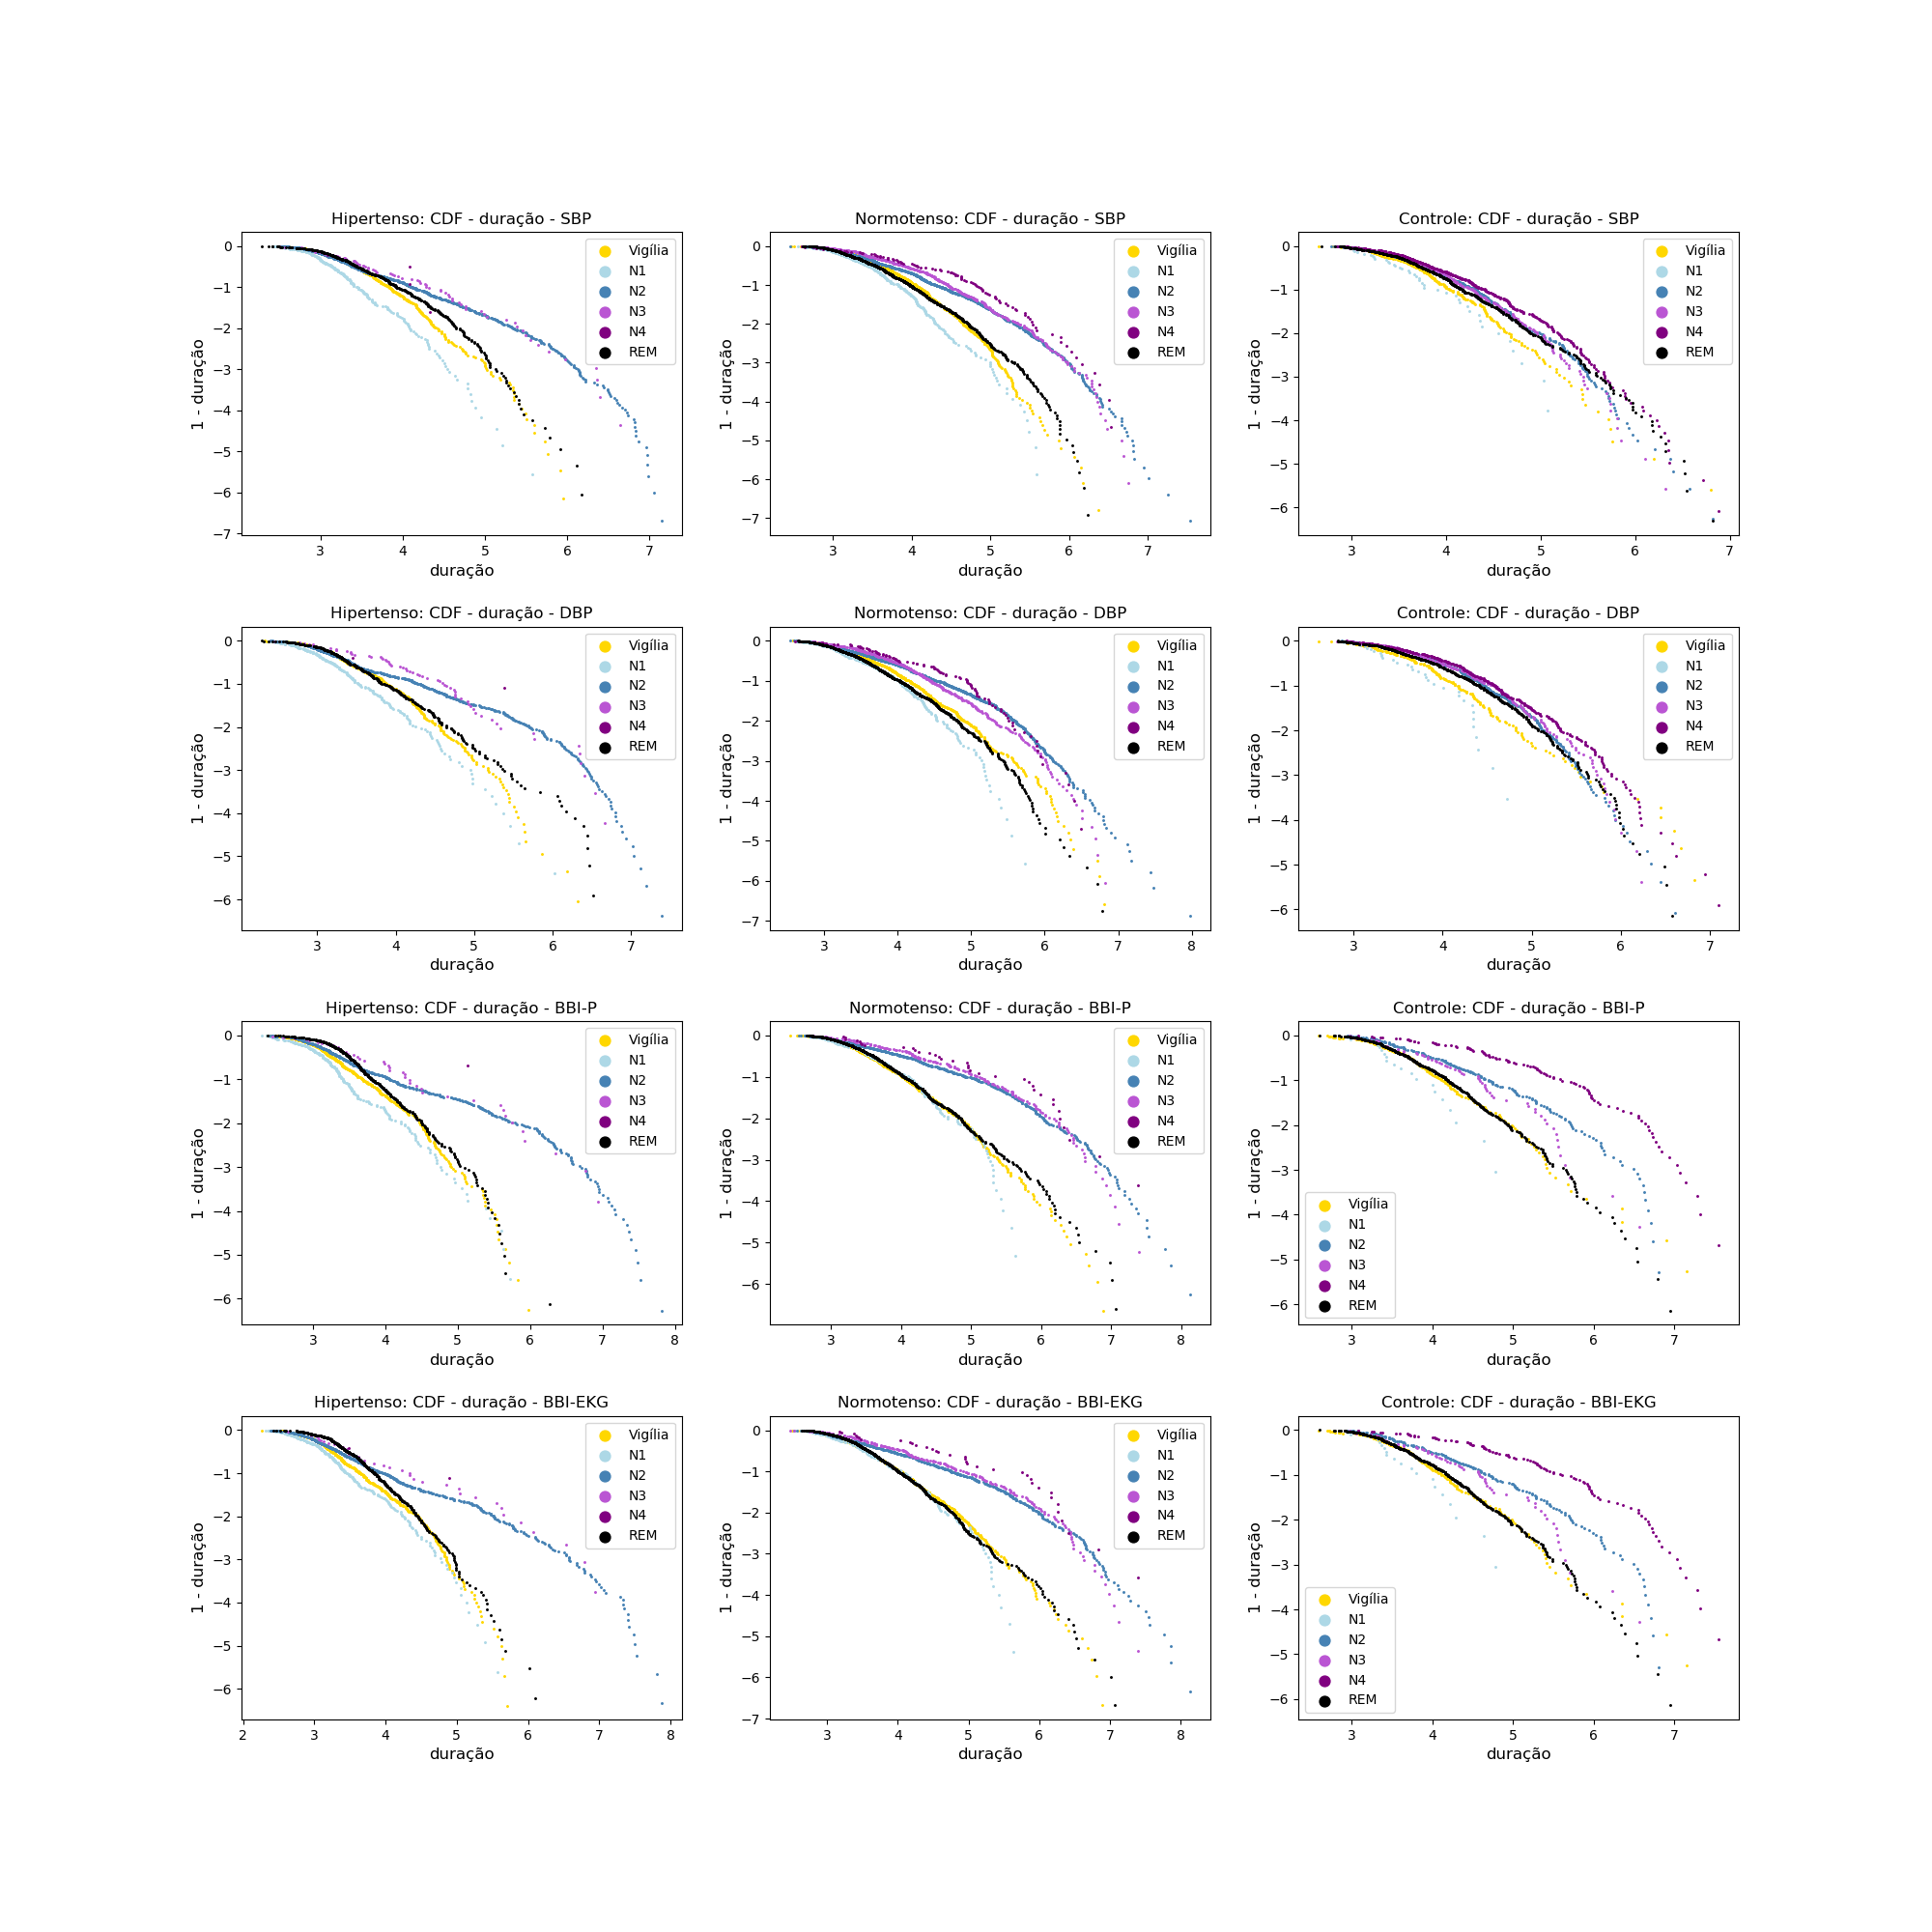

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


In [122]:
# Curva de Distribuição Empírica

#Criação dos frames para a curva de distribuição empirica
fig_dt_cdf, axs_dt_cdf     = plt.subplots(nrows = 4, ncols = 3)

# Criação das listas para iteração
colors    = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
t_grupo   = ["Hipertenso", "Normotenso", "Controle"]
t_serie   = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
t_medidas = ["duração"]
labels = ["Vigília", "N1", "N2", "N3", "N4", "REM"]
lista_axs = [axs_dt_cdf]
lista_figs = [fig_dt_cdf]
lista_medidas = [delta_t]

# Configura o tamanhos das figuras e distâncias entre os eixos
for item in lista_figs:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for ax_arr in lista_axs:
    for i in range(4):
        for j in range(3):
            ax_arr[i][j].title.set_fontsize(14)
            ax_arr[i][j].xaxis.label.set_fontsize(12)
            ax_arr[i][j].yaxis.label.set_fontsize(12)
            
# Definição dos títulos
stages = ["0", "1", "2", "3", "4", "REM"]
ylabels = ["duração"]



# Plota as curvas de distribuição empírica
for m in range(len(lista_medidas)):
    for grupo in [0, 1, 2]:
        for serie in [0, 1, 2, 3]:
            medida = lista_medidas[m][grupo][serie]
            
            # Calcula o vetor da função de distribuição acumulada
            Fn = [[], [], [], [], [], []]
            for i in range(6):
                medida[i].sort()
                Fn[i] = -np.sort(-np.arange(len(medida[i]))/float(len(medida[i])))
            
            
            
            for i in range(6):
                ax = lista_axs[m][serie][grupo]
                ax.scatter(np.log(medida[i]), np.log(Fn[i]), color = colors[i], s = 5, label = labels[i], marker = '.')
                ax.set_xlabel(t_medidas[m])
                ax.set_ylabel('1 - '+ylabels[m])
                ax.set_title(t_grupo[grupo]+": CDF - "+t_medidas[m]+" - "+t_serie[serie])
                ax.legend(fontsize = 10, markerscale = 7)
            

##### Conditional PDF
***

Em que consiste essa figura?

Um meio de investigar a não-estacionariedade dos grupos. Como isso se dá? A segmentação oferece um meio de investigar o comportamento da variância. Para uma série mais próxima da estacionariedade, deveríamos ter pouca variabilidade da variância, independentemente dos tamanhos dos segmentos.

Há diferenças nas aglomerações dos dados entre os grupos? O que pode significar essa diferença?

O que diz a presença de uma tendência dos valores (e, da mesma forma, a ausência de tendência)?





****
Teste. Considerando todos os segmentos de cada individuo, aglomerando os dados por grupo, para evitar distorções e testar o algoritmo, comparando-o com o resultado do paper.

Obs: Os pontos para as séries de intervalos entre batimentos não se alinham tão bem. Por quê?

Duv: Como fazer para que apareça uma reta aproximando os pontos com eixos em escala logarítmica? Qual curva deve ser aproximada?

<IPython.core.display.Javascript object>


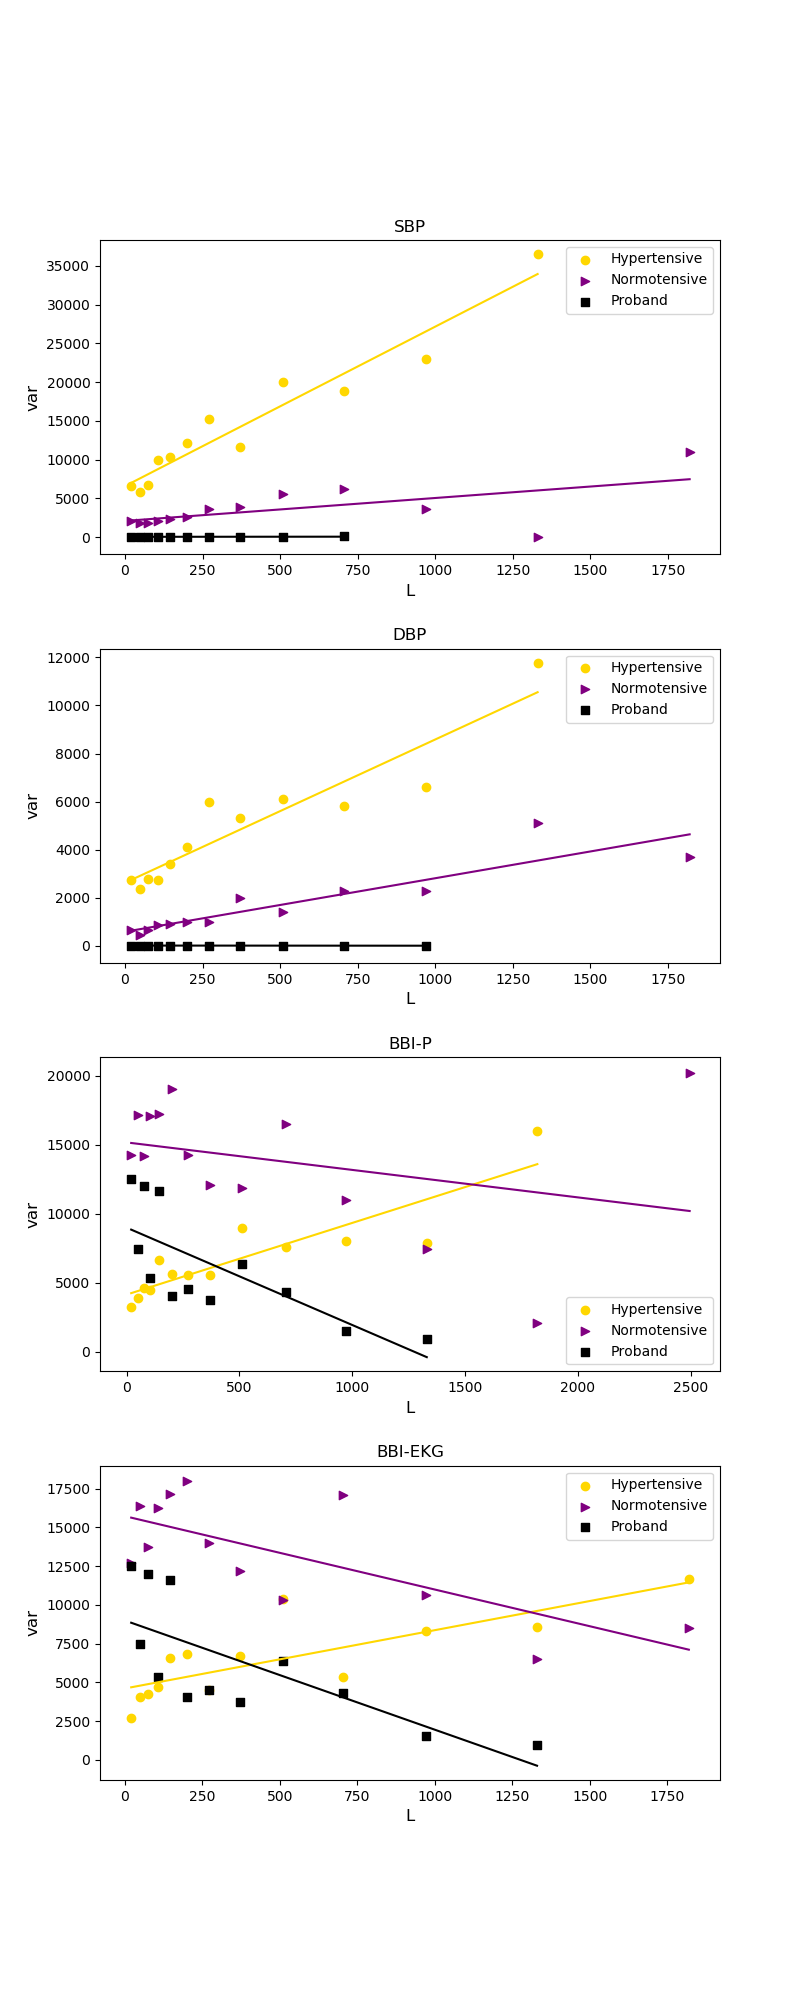

In [358]:
# Definição da reta para aproximação.
def line(x, a, b):
    return a*x + b

# Gera a figura para o plot
fig, axs = plt.subplots(nrows = 4, ncols = 1) # 4 séries, 3 grupos

# Configura o tamanho da figura e distâncias entre os eixos
fig.set_size_inches(8, 20)
fig.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Configura o tamanho das fontes dos títulos
for i in range(4):
    axs[i].title.set_fontsize(14)
    axs[i].xaxis.label.set_fontsize(12)
    axs[i].yaxis.label.set_fontsize(12)

# Define itens de formatação
colors    = ["gold", "purple", "black"]
markers   = ["o", ">", "s"]
labels = ["Hypertensive", "Normotensive", "Proband"]
series_labels = ["SBP", "DBP", "BBI-P", "BBI-EKG"]


for s in range(4):
    for g in range(3):
        # Cria uma estrutura contendo tamanho, duração e variância de todos os segmentos, de todos 
        # os individuos de um grupo 'g'
        df = pd.DataFrame()
        for i in range(len(seg_res[g])):
            df = pd.concat([df, seg_res[g][i][s].dropna()[["size", "Dt", "variance"]]])
                
        # Gera os pontos do eixo x, espaçados igualmente em escala logarítmica.
        # O número de pontos definido contempla todo o intervalo de pontos do tamanho
        interval_log = np.zeros(16); lim = np.zeros(16);
        for i in range(1, 16):
            interval_log[i] = int(np.power(1.37, i+4))
            lim[i] = 10*(interval_log[i]+interval_log[i-1])/2


        dif = np.empty(0)
        l   = np.empty(0)
        var = np.empty(0)

        for k in range(1, 15):
            # Seleciona, na estrutura, os segmentos dentro de uma faixa especificada
            temp = df.where((df["size"] < lim[k+1]) & (df["size"] >= lim[k])).dropna()
            # Se há pelo menos um segmento, calcula a média da variância dos segmentos 
            # e os pontos correspondentes do eixo x
            if len(temp) > 0:
                dif = np.append(dif, (lim[k+1] - lim[k])/2)
                l   = np.append(l, lim[k])
                var = np.append(var, temp["variance"].values.mean())
        
        # Aproxima uma reta para os pontos
        par, pcov = curve_fit(line, l, var)
        axs[s].scatter(l, var, color = colors[g], marker = markers[g], label = labels[g])
        axs[s].plot(l, line(l, *par), color = colors[g])
        
    axs[s].set_title(series_labels[s])
    axs[s].set_xlabel("L")
    axs[s].set_ylabel("var")
    axs[s].legend(fontsize = 10, markerscale = 1)
    #axs[s].set_yscale('log')
    #axs[s].set_xscale('log')

***

Plot agrupando os dados por fases do sono.

***

Há alguns problemas.
    1. O volume de segmentos de cada fase não é igual em cada grupo. A fase N4, por exemplo, aparece raramente nos indivíduos do grupo hipertenso. Portanto, poucos pontos aparecem na figura. A fase N2 aparece frequentemente em todos os grupos, portanto vários pontos aparecem na figura, e dá para ver alguma tendência para esses valores, mas...
    2. ... no geral, todos os pontos estão dispersos demais. Aproximei retas para os dados plotados nos eixos normais (pois preciso verificar qual curva aproximo para os eixos em escala logarítmica), mas isso é pouco significativo dada a dispersão dos pontos, e não é possível encontrar padrão algum. Em escala logarítmica os pontos estão mais organizados (pode-se compará-los verticalmente), mas também não parece haver padrão algum.
    3. A aglomeração de valores em um dos cantos do gráfico reafirma a similaridade das fases em relação aos segmentos de tamanhos menores. Há a interseção de faixas de valores e proximidade das curvas de distribuição empírica. Aqui, há a similaridade das variâncias. As discrepâncias aparecem somente em segmentos de tamanhos maiores. O fato de haver discrepância denota que a fase é uma influência (não depende apenas do tamanho do segmento).
    
Posso abandonar alguma possibilidade, dado esse resultado?

Talvez classificar os segmentos e buscar diferenças não seja o melhor jeito de investigar.

<IPython.core.display.Javascript object>


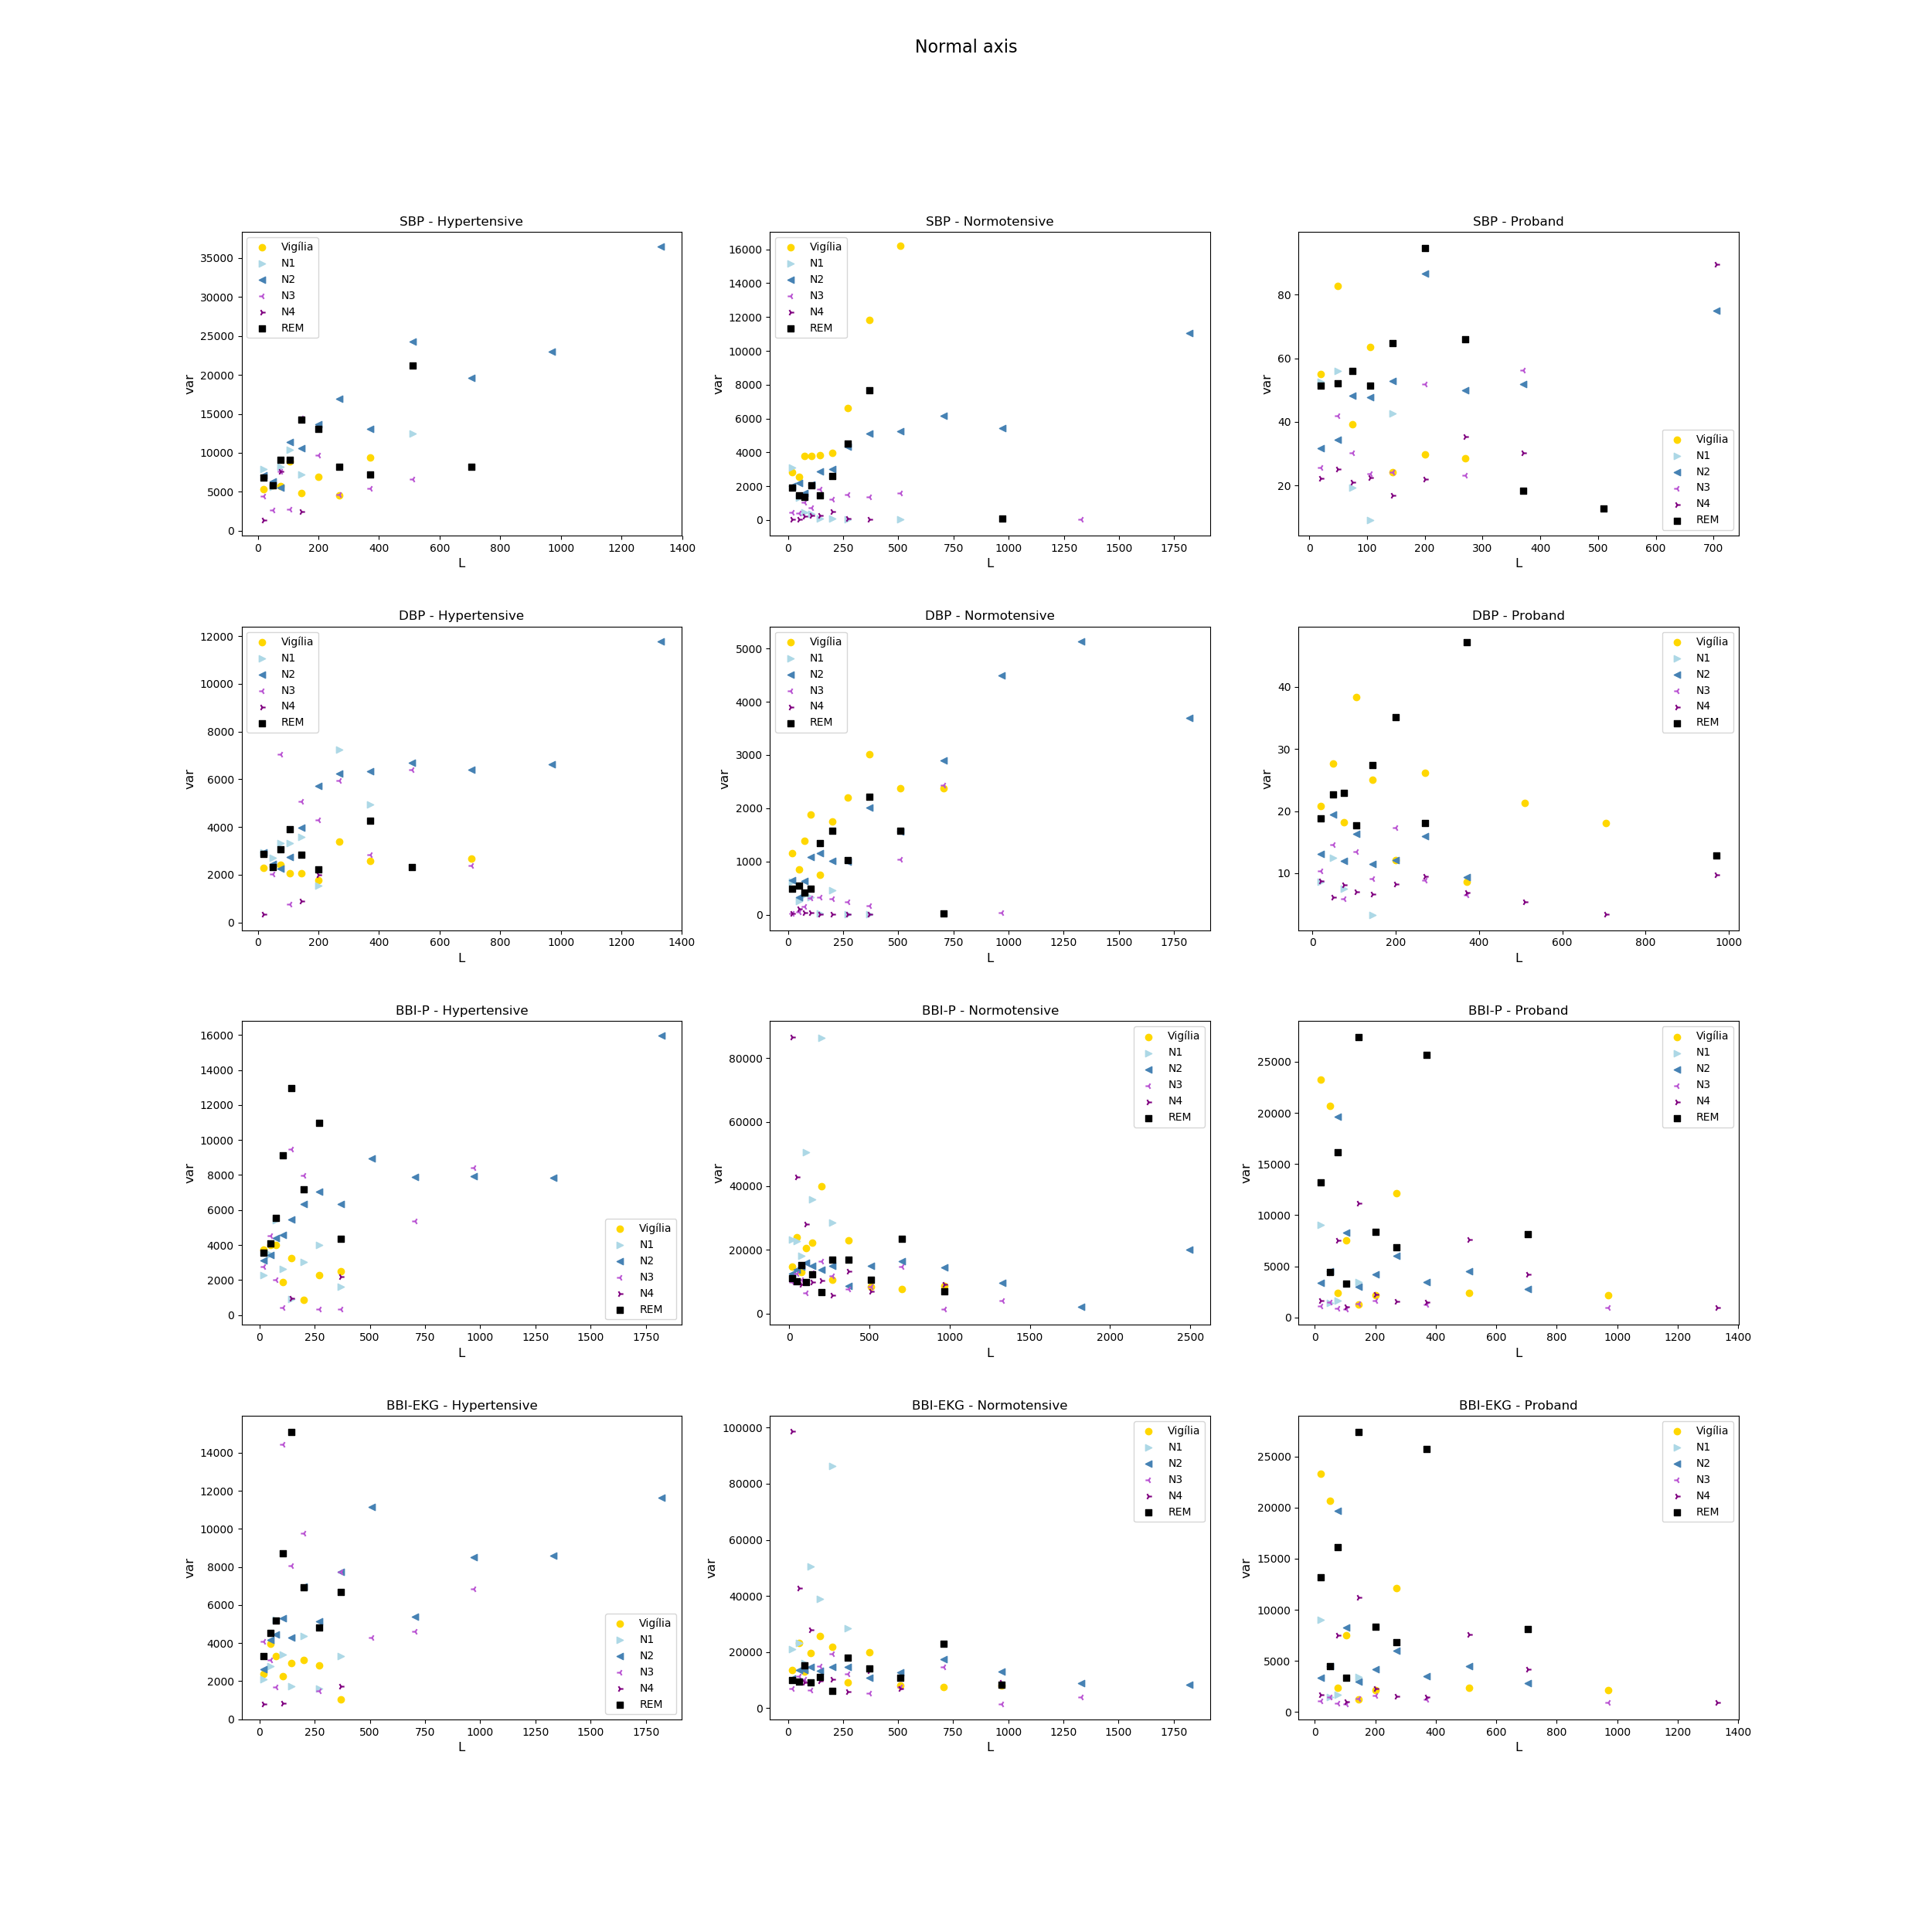

<IPython.core.display.Javascript object>


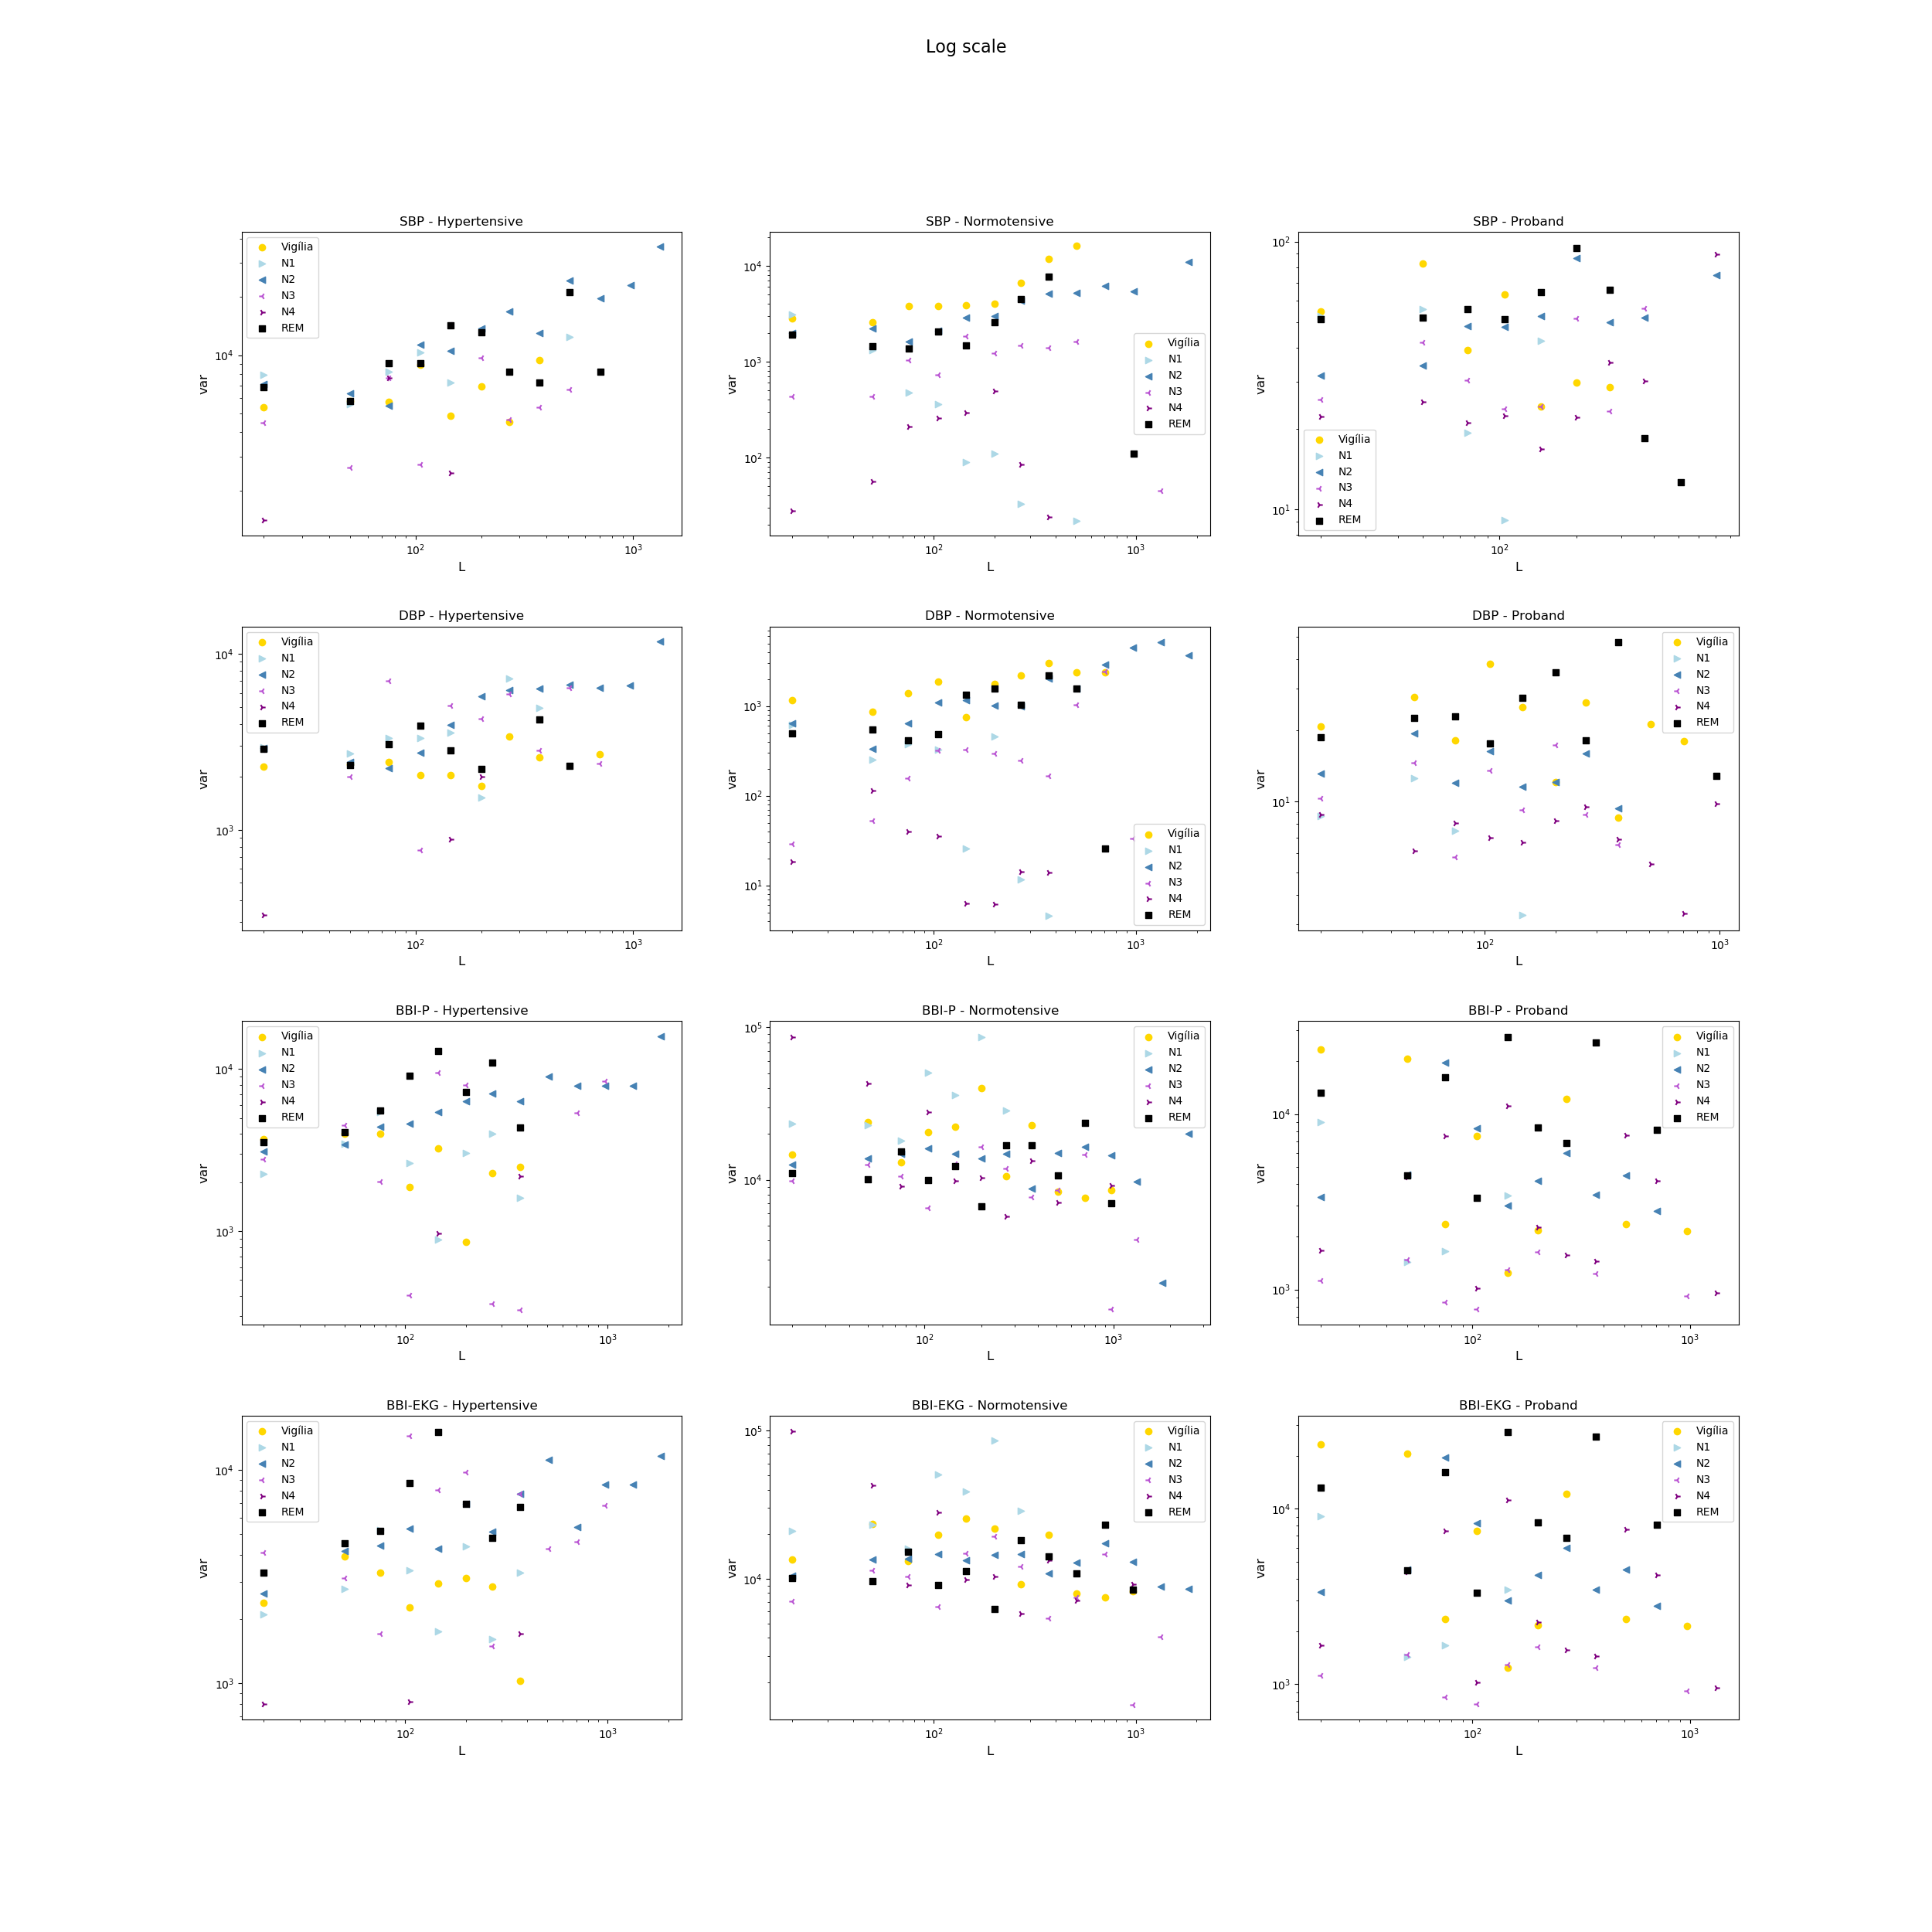

In [365]:
# Gera a figura para o plot
fig_norm, axs_norm = plt.subplots(nrows = 4, ncols = 3) # 4 séries, 3 grupos
fig_log, axs_log = plt.subplots(nrows = 4, ncols = 3) # 4 séries, 3 grupos

# Configura o tamanho da figura e distâncias entre os eixos
for fig in [fig_norm, fig_log]:
    fig.set_size_inches(25, 25)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.2)
    
# Títulos das figuras
fig_norm.suptitle("Normal axis", fontsize = 16)
fig_log.suptitle("Log scale", fontsize = 16)

# Configura o tamanho das fontes dos títulos
for axs in [axs_norm, axs_log]:
    for i in range(4):
        for j in range(3):
            axs[i][j].title.set_fontsize(14)
            axs[i][j].xaxis.label.set_fontsize(12)
            axs[i][j].yaxis.label.set_fontsize(12)

# Define itens de formatação
colors    = ["gold", "lightblue", "steelblue", "mediumorchid", "purple", "black"]
markers   = ["o", ">", "<", "3", "4", "s"]
labels = ["Vigília", "N1", "N2", "N3", "N4", "REM"]
g_labels = ["Hypertensive", "Normotensive", "Proband"]
s_labels = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

for f in range(6): # Fases
    
    for s in range(4): # Séries
        for g in range(3): # Grupos
            # Guarda em uma estrutura os dados de tamanho, duração e variância dos segmentos de uma série 's',
            # classificados por uma fase 'f', de todos os indivíduos de um grupo 'g'.
            df = pd.DataFrame()
            for i in range(len(seg_res[g])):
                df = pd.concat([df, seg_res[g][i][s].where(seg_res[g][i][s]["SleepStage"] == f).dropna()[["size", "Dt", "variance"]]])
                
            # Gera os pontos do eixo x, espaçados igualmente em escala logarítmica.
            # O número de pontos definido contempla todo o intervalo de pontos do tamanho 
            interval_log = np.zeros(16); lim = np.zeros(16);
            for i in range(1, 16):
                interval_log[i] = int(np.power(1.37, i+4))
                lim[i] = 10*(interval_log[i]+interval_log[i-1])/2


            dif = np.empty(0) # era para ser o ponto médio?
            l   = np.empty(0) # vetor para guardar os pontos extremos dos bins
            var = np.empty(0) # vetor para guardar as variâncias

            for k in range(1, 15):
                # Seleciona, na estrutura, os segmentos dentro de uma faixa especificada
                temp = df.where((df["size"] < lim[k+1]) & (df["size"] >= lim[k])).dropna()
                # Se há pelo menos um segmento, calcula a média da variância dos segmentos 
                # e os pontos correspondentes do eixo x
                if len(temp) > 0:
                    
                    dif = np.append(dif, (lim[k+1] - lim[k])/2)
                    l   = np.append(l, lim[k])
                    var = np.append(var, temp["variance"].values.mean())
                
            # Plota o scatter para os dados nos eixos em escala logarítmica
            axs_log[s][g].scatter(l, var, color = colors[f], marker = markers[f], label = labels[f])
            # Aproxima uma reta para os dados.
            #par, pcov = curve_fit(line, l, var)
            # Plota o scatter para os dados nos eixos normais.
            axs_norm[s][g].scatter(l, var, color = colors[f], marker = markers[f], label = labels[f])
            # Plota as curvas aproximadas nos eixos normais.
            #axs_norm[s][g].plot(l, line(l, *par), color = colors[f])
            
            # Modifica os eixos para escala logaritmica
            axs_log[s][g].set_yscale('log')
            axs_log[s][g].set_xscale('log')
            
            # Formatação e legendas dos eixos
            for axs in [axs_log, axs_norm]:
                axs[s][g].legend(fontsize = 10, markerscale = 1)
                axs[s][g].set_title(s_labels[s]+" - "+g_labels[g])
                axs[s][g].set_xlabel("L")
                axs[s][g].set_ylabel("var")
                

fig_norm.savefig("Plots/var_L_normal.png")
fig_log.savefig("Plots/var_L_escalalog.png")